In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications.densenet import DenseNet121

In [ ]:
disease_types = ['Pepper__bell___Bacterial_spot','Pepper__bell___healthy','Tomato__Target_Spot','Tomato__Tomato_YellowLeaf__Curl_Virus','Tomato_Bacterial_spot','Tomato_Early_blight','Tomato_healthy','Tomato_Late_blight','Tomato_Septoria_leaf_spot','Tomato_Spider_mites_Two_spotted_spider_mite']
data_dir = ('/content/drive/MyDrive/PlantVillage')
train_dir = os.path.join(data_dir)
#test_dir = os.path.join(data_dir, 'test')

In [ ]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.tail()

,File,DiseaseID,Disease Type
16969,Tomato_Spider_mites_Two_spotted_spider_mite/62...,9,Tomato_Spider_mites_Two_spotted_spider_mite
16970,Tomato_Spider_mites_Two_spotted_spider_mite/63...,9,Tomato_Spider_mites_Two_spotted_spider_mite
16971,Tomato_Spider_mites_Two_spotted_spider_mite/66...,9,Tomato_Spider_mites_Two_spotted_spider_mite
16972,Tomato_Spider_mites_Two_spotted_spider_mite/62...,9,Tomato_Spider_mites_Two_spotted_spider_mite
16973,Tomato_Spider_mites_Two_spotted_spider_mite/62...,9,Tomato_Spider_mites_Two_spotted_spider_mite


In [ ]:
# Randomize the order of training set
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,Tomato_Early_blight/ba789eab-7c04-4012-b8fa-98...,5,Tomato_Early_blight
1,Tomato__Tomato_YellowLeaf__Curl_Virus/657a028b...,3,Tomato__Tomato_YellowLeaf__Curl_Virus
2,Tomato__Tomato_YellowLeaf__Curl_Virus/2f22e16c...,3,Tomato__Tomato_YellowLeaf__Curl_Virus
3,Tomato__Tomato_YellowLeaf__Curl_Virus/6a4dee9a...,3,Tomato__Tomato_YellowLeaf__Curl_Virus
4,Tomato__Tomato_YellowLeaf__Curl_Virus/1ae01cae...,3,Tomato__Tomato_YellowLeaf__Curl_Virus


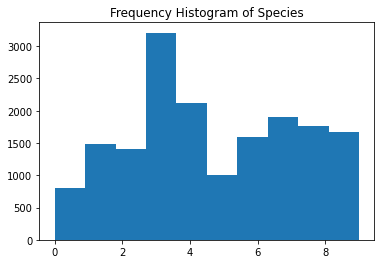

<Figure size 864x864 with 0 Axes>

In [ ]:
# Plot a histogram
plt.hist(train['DiseaseID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

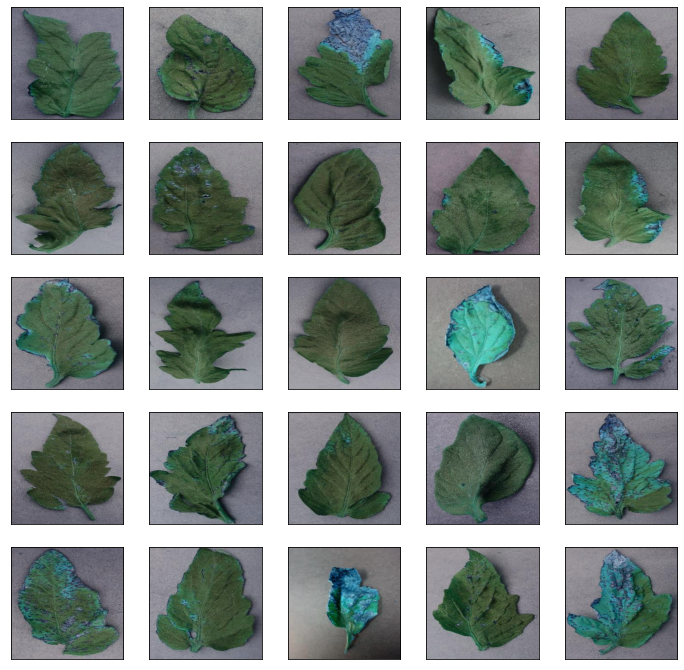

In [ ]:
# Display images for different species
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('Tomato_Bacterial_spot', 5, 5)

In [ ]:
IMAGE_SIZE = 64

def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [ ]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

16974it [2:59:25,  1.58it/s]


Train Shape: (16974, 64, 64, 3)


In [ ]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=15)

In [ ]:
BATCH_SIZE = 32

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

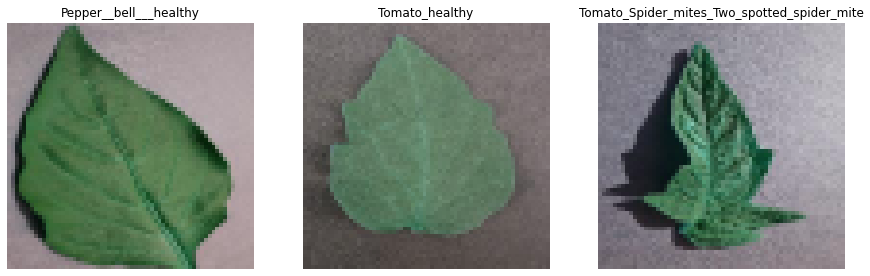

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

In [ ]:
EPOCHS = 50
SIZE=64
N_ch=3

In [ ]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    # multi output
    output = Dense(15,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [ ]:
model = build_densenet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 3)         84        
                                                                 
 densenet121 (Functional)    (None, None, None, 1024)  7037504   
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_2 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0   

In [ ]:
#model = load_model('../output/kaggle/working/model.h5')
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

107/107 [==============================] - 2s 19ms/step - loss: 0.2259 - accuracy: 0.9255
Final Loss: 0.22585704922676086, Final Accuracy: 0.9254786372184753


Text(0.5, 144.41374999999996, 'Predicted')

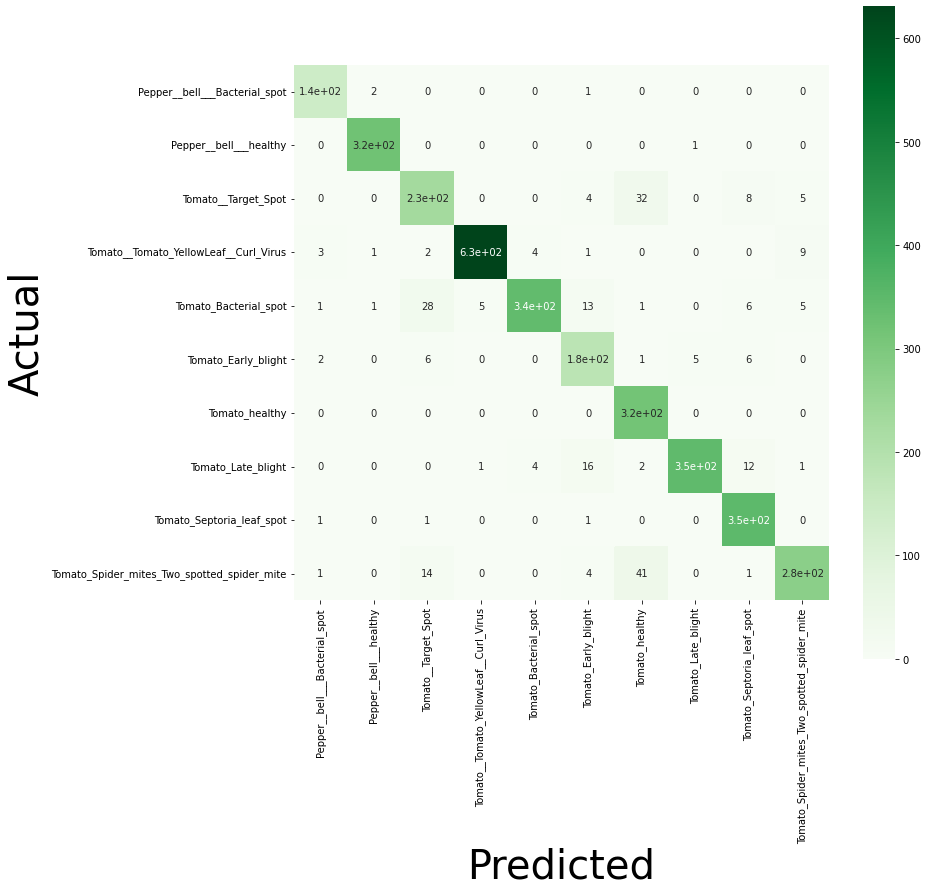

In [ ]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

In [ ]:
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score

In [ ]:
print(accuracy_score(Y_true, Y_pred))
print(f1_score(Y_true, Y_pred, average="macro"))
print(precision_score(Y_true, Y_pred, average="macro"))
print(recall_score(Y_true, Y_pred, average="macro")) 

0.925478645066274
0.918282354529888
0.917508596684341
0.9238691364771572


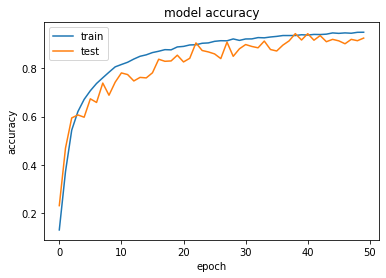

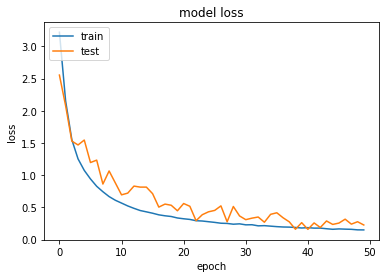

In [ ]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[1.3414963e-01 8.3617109e-01 4.5135410e-05 4.4866368e-07 4.0820272e-08
 1.1053400e-05 1.8353567e-02 4.9444304e-07 2.3338627e-03 2.5975787e-06
 7.0113468e-04 2.5211114e-03 2.9078941e-04 1.8245600e-04 5.2366480e-03]


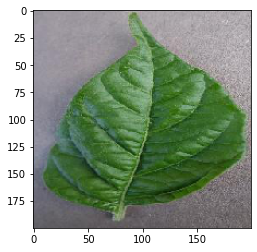

Prediction: Pepper__bell___healthy


In [ ]:
from skimage import io
from keras.preprocessing import image
#path='imbalanced/Scratch/Scratch_400.jpg'
img = image.load_img('/content/drive/MyDrive/PlantVillage/Pepper__bell___healthy/00726ad4-2569-46ce-9d4e-dbf82b14bd94___JR_HL 8686.JPG', grayscale=False, target_size=(64, 64))
show_img=image.load_img('/content/drive/MyDrive/PlantVillage/Pepper__bell___healthy/00726ad4-2569-46ce-9d4e-dbf82b14bd94___JR_HL 8686.JPG', grayscale=False, target_size=(200, 200))
disease_class = ['Pepper__bell___Bacterial_spot','Pepper__bell___healthy','Tomato__Target_Spot','Tomato__Tomato_YellowLeaf__Curl_Virus','Tomato_Bacterial_spot','Tomato_Early_blight','Tomato_healthy','Tomato_Late_blight','Tomato_Septoria_leaf_spot','Tomato_Spider_mites_Two_spotted_spider_mite']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
#x = np.array(x, 'float32')
x /= 255

custom = model.predict(x)
print(custom[0])



#x = x.reshape([64, 64]);

#plt.gray()
plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])

In [ ]:
import tkinter as tk
from tkinter import filedialog
from tkinter.filedialog import askopenfile

In [ ]:
!apt-get install -y xvfb
import os
os.system('Xvfb :1 -screen 0 1600x1200x16  &')    # create virtual display with size 1600x1200 and 16 bit color. Color can be changed to 24 or 8
os.environ['DISPLAY']=':1.0' 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
import tkinter as tk
from tkinter import filedialog
from tkinter.filedialog import askopenfile
from PIL import Image, ImageTk
my_w = tk.Tk()
my_w.geometry("400x300")  # Size of the window 
my_w.title('Detect disease')
my_font1=('times', 18, 'bold')
l1 = tk.Label(my_w,text='Detect disease',width=30,font=my_font1)  
l1.grid(row=1,column=1)
l2 = tk.Label(my_w,text='')  
l2.grid(row=3,column=2)
l3 = tk.Label(my_w,text='')  
l3.grid(row=3,column=3)
b1 = tk.Button(my_w, text='Upload File', 
   width=20,command = lambda:upload_file())
b1.grid(row=2,column=1) 
b2 = tk.Button(my_w, text='disease type',
width=20, command = lambda: l2.config(text=disease_class[ind]))
b2.grid(row=2,column=2) 


def upload_file():
    global img
    f_types = [('Files', '*.png, *.jpg')]
    filename = filedialog.askopenfilename(filetypes=f_types)
    img=Image.open(filename)
    img_resized=img.resize((400,200)) # new width & height
    img=ImageTk.PhotoImage(img_resized)
    b2 =tk.Button(my_w,image=img) # using Button 
    b2.grid(row=3,column=1)
      
my_w.mainloop()  # Keep the window open